# Simulating an action potential


In this example, we're going to use Myokit to simulate an action potential (AP), using [a model of the human ventricular AP](https://doi.org/10.1152/ajpheart.00109.2006) by ten Tusscher et al.
You can download a copy of the model here: [tentusscher-2006.mmt](models/tentusscher-2006.mmt).

This model has been implemented in Myokit's ["mmt syntax"](https://myokit.readthedocs.io/syntax/index.html) (basically an ini file with equations in it). But in this example we won't focus on the equations much, and instead just run a few simulations.

## Loading a model and protocol

Two things are needed to create a Myokit [Simulation](https://myokit.readthedocs.io/api_simulations/Simulation.html): a model and a protocol.

The [Model](https://myokit.readthedocs.io/api_core/Model.html) contains all the equations, and a few annotations that tell the simulator where to find specific variables (e.g. the variable representing time).
A [Protocol](https://myokit.readthedocs.io/api_simulations/Protocol.html) is used to apply external stimuli to the cell, for example a periodic pacing signal (for current-clamp simulations) or a sequence of voltage steps (for voltage-clamp simulation).

Myokit's `mmt` files contain a model, a protocol, and usually an example script as well, so you can load all three from a file:

In [2]:
import myokit

model, protocol, script = myokit.load('models/tentusscher-2006.mmt')

You don't have to load all three at once, there are also methods to load the specific bits you need:

In [3]:
model = myokit.load_model('models/tentusscher-2006.mmt')
protocol = myokit.load_protocol('models/tentusscher-2006.mmt')

Alternatively, if you're using the Myokit IDE, you can load a model and a protocol using the methods `get_model()` and `get_protocol()`.

## Creating a simulation

We now combine the Model and Protocol objects to create a simulation:

In [4]:
sim = myokit.Simulation(model, protocol)

You might notice this step takes a little longer than loading the model and protocol.
This is because a myokit Simulation is a *compiled object*: it takes the equations from the Model, converts them to C, links to an ODE solver library, adds some Python wrappers, and then compiles the lot.
But let's not worry about that for now...

## Running and visualising the results

Once created, we can run the simulation:

In [5]:
d = sim.run(1000)

This simulates 1000 time units: In most models that means 1000ms, but in some models this will be a 1000 seconds, so best to check before running.

Simulation results are returned in the form of a [DataLog](https://myokit.readthedocs.io/api_simulations/DataLog.html).
This is a wrapper around Python's dictionary type, and allows you to access all logged variables using their "fully qualified names" as keys:

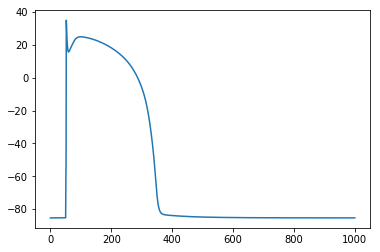

In [7]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(d['engine.time'], d['membrane.V'])
plt.show()

_(Here, "membrane.V" is an example of a fully qualified name, which is made up of the component name "membrane", a dot, and the variable name "V". A fully qualified name uniquely identifies a component or variable within a model.)_

Because data logs are [dicts](https://docs.python.org/3/library/stdtypes.html#typesmapping), you can see a list of the logged variables using the `.keys()` method:

In [8]:
print(d.keys())

odict_keys(['membrane.V', 'calcium.Cai', 'calcium.CaSR', 'calcium.CaSS', 'sodium.Nai', 'potassium.Ki', 'ina.m', 'ina.h', 'ina.j', 'ikr.xr1', 'ikr.xr2', 'iks.xs', 'ito.r', 'ito.s', 'ical.d', 'ical.f', 'ical.f2', 'ical.fCaSS', 'jrel.R_prime', 'engine.time', 'engine.pace', 'membrane.i_ion', 'stimulus.i_stim', 'ina.INa', 'ina.m.inf', 'ina.m.tau', 'ina.m.alpha', 'ina.m.beta', 'ina.h.inf', 'ina.h.tau', 'ina.h.alpha', 'ina.h.beta', 'ina.j.inf', 'ina.j.tau', 'ina.j.alpha', 'ina.j.beta', 'ik1.IK1', 'ik1.inf', 'ik1.inf.alpha', 'ik1.inf.beta', 'ikr.IKr', 'ikr.xr1.inf', 'ikr.xr1.tau', 'ikr.xr1.alpha', 'ikr.xr1.beta', 'ikr.xr2.inf', 'ikr.xr2.tau', 'ikr.xr2.alpha', 'ikr.xr2.beta', 'iks.IKs', 'iks.xs.inf', 'iks.xs.tau', 'iks.xs.alpha', 'iks.xs.beta', 'ito.Ito', 'ito.r.inf', 'ito.r.tau', 'ito.s.inf', 'ito.s.tau', 'ical.ICaL', 'ical.d.inf', 'ical.d.tau', 'ical.d.alpha', 'ical.d.beta', 'ical.d.gamma', 'ical.f.inf', 'ical.f.tau', 'ical.f2.inf', 'ical.f2.tau', 'ical.fCaSS.inf', 'ical.fCaSS.tau', 'inak.INa

Alternatively, you can have a look at the model code.

For example, the model we used contains this snippet:

```
[engine]
time = 0
    in [ms]
    bind time
```

this defines a component called "engine", and a variable called "time" that has units millisecond.
The final line indicates that this is a special variable that represents time.


To access the variable `time` from the component `engine`, we use the syntax `engine.time`.

Further down in the model we find:

```
[membrane]
dot(V) = -(i_ion + i_stim + i_diff)
    in [mV]
```

this defines a component `membrane` with a variable `V` (defined through its time-derivative $\dot{V}$), that we can obtain from the log as `membrane.V`.

We can look up other variables in the model, and plot them instead of V. For example, we could have a look at the calcium transient, which in this model means plotting the variable `calcium.Ca_i`:

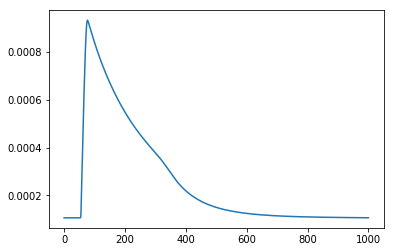

In [10]:
plt.figure()
plt.plot(d['engine.time'], d['calcium.Cai'])
plt.show()

In fact, we can do a little better than that, and add proper axis labels:

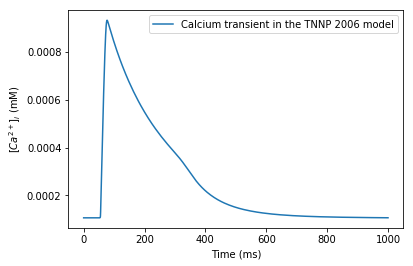

In [11]:
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('$[Ca^{2+}]_i$ (mM)')
plt.plot(d['engine.time'], d['calcium.Cai'], label='Calcium transient in the TNNP 2006 model')
plt.legend()
plt.show()

In these examples, we'll use [Matplotlib](https://matplotlib.org/) to do the plotting, but other libraries are available that work with Myokit just as well.

To plot the results outside of Python, we can export a simulation log to [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) using `d.save_csv('results.csv')`.

## Conclusion

So that's it!
You can load models and protocols with `myokit.load()`, then create a `myokit.Simulation`, run it with `run()` and visualise the results by fetching them from the returned `DataLog`.

In the next examples, we'll play around with the Simulation object some more.